<a href="https://colab.research.google.com/github/esther0402/NLP_Projects/blob/main/Shakespeare_Sonnet_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to build a model that predict the next word in a text sequence, built on a corpus of Shakespeare's sonnets.

##Getting the data

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [22]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 54.9MB/s]


In [23]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


##Tokenizing the text

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

This code receives the fitted tokenizer and the corpus (which is a list of strings) and returns a list containing the `n_gram` sequences for each line in the corpus.

In [25]:
def n_gram_seqs(corpus, tokenizer):
  input_seq = []

  for line in corpus:
    #tokenize the current line
    token_list_line = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list_line)):
      #generate subphrases
      n_gram_seq = token_list_line[:i+1]
      input_seq.append(n_gram_seq)

  return input_seq

In [26]:
#Testing the function with one example

first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

This code then applies the `n_gram_seqs` transformation to the whole corpus and saves the maximum sequence length to use it later.

In [27]:
input_sequences = n_gram_seqs(corpus, tokenizer)
print(f"n_grams of input_sequences have length: {len(input_sequences)}")

max_sequence_len = max([len(x) for x in input_sequences])
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


##Adding padding to the sequences

This code pads tokenized sequences to the same length.

In [28]:
def pad_seqs(input_sequences, maxlen):
  padded_sequences = pad_sequences(
      input_sequences,
      maxlen = maxlen
      )

  return padded_sequences


In [29]:
#testing the padding function
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [30]:
#padding the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)
print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


There iare 15,462 sequences and each sequence has a length of 11.

##Splitting the data into features and labels

Before feeding the data into the neural network the data will be split into features (input data)and labels (output).
* The features will be the padded n_gram sequences with the last word removed from them
* The labels will be the removed word

This code expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

In [34]:
from tensorflow.keras.utils import to_categorical

def features_and_labels(padded_sequences, total_words):
  features = []
  labels = []

  for sequence in padded_sequences:
      # Extract the last word as the label
      label = sequence[-1]
      # Remove the last word to create the feature
      feature = sequence[:-1]

      features.append(feature)
      labels.append(label)

  # One-hot encode the labels
  one_hot_labels = to_categorical(labels, num_classes=total_words)

  return features, one_hot_labels


In [32]:
#Testing the function
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



[array([ 0,  0,  0,  0, 34], dtype=int32),
 array([  0,   0,   0,  34, 417], dtype=int32),
 array([  0,   0,  34, 417, 877], dtype=int32),
 array([  0,  34, 417, 877, 166], dtype=int32),
 array([ 34, 417, 877, 166, 213], dtype=int32)]

In [37]:
# Splitting the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

# Converting to np arrays (for NNs)
features = np.array(features)
labels = np.array(labels)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


##Creating the Model

In [41]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

def create_model(total_words, max_sequence_len):
    """
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    model.add(Embedding(total_words, 200, input_length=max_sequence_len-1)), #100
    model.add(Bidirectional(LSTM(250))), #150
    model.add(Dense(total_words, activation = 'softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),#0.001
                  metrics=['accuracy'])

    return model

Training the model:

In [42]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 67s 126ms/step - loss: 6.8491 - accuracy: 0.0231
Epoch 2/50
484/484 [==============================] - 62s 128ms/step - loss: 6.3690 - accuracy: 0.0368
Epoch 3/50
484/484 [==============================] - 62s 128ms/step - loss: 6.0501 - accuracy: 0.0488
Epoch 4/50
484/484 [==============================] - 60s 125ms/step - loss: 5.6845 - accuracy: 0.0649
Epoch 5/50
484/484 [==============================] - 61s 125ms/step - loss: 5.2292 - accuracy: 0.0825
Epoch 6/50
484/484 [==============================] - 60s 124ms/step - loss: 4.6712 - accuracy: 0.1160
Epoch 7/50
484/484 [==============================] - 59s 123ms/step - loss: 4.0392 - accuracy: 0.1832
Epoch 8/50
484/484 [==============================] - 59s 123ms/step - loss: 3.3837 - accuracy: 0.2936
Epoch 9/50
484/484 [==============================] - 60s 124ms/step - loss: 2.7850 - accuracy: 0.4075
Epoch 10/50
484/484 [==============================] - 60s 124ms/step - l

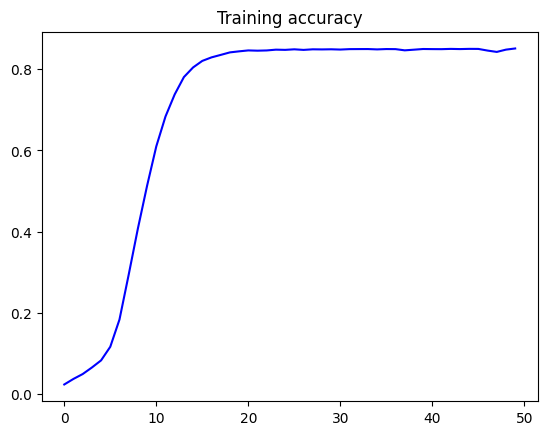

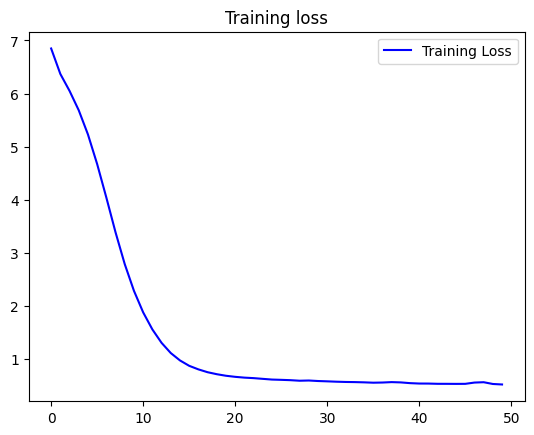

In [43]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

##Seeing the model in action

This code generates text after reading the seed_text (which can be modified).

In [45]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my love another best hate new mayst still ' new so dear know in my heart forbear that truth doth face ere long ' see the where hand it may see dead faults seeing so doth greater ' canst know what merit do now love and me well alter'd lies wrong could new ' ' ' thou art much too fair and mine eye untrue eyes one tongue that tongue debarr'd stone to mend the pebbled shore at cross decrease head transfix growth on me now stand thee doth be dead ' ' swear doth art art more so fair
